<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --Addition
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


### Data Cleaning

In [3]:
%run -i test.py

### Remove NOT "Residential" from dataset

In [6]:
house.isnull().sum();

In [7]:
## 2. Be sure to remove any houses that are not residential from the dataset.
# Target Column : MSZoning

print(house['MSZoning'].count())
print(house['MSZoning'].value_counts())

## Drop row with value "C (all)"
house = house[house['MSZoning'] != 'C (all)']
print(house['MSZoning'].unique())

1460
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
['RL' 'RM' 'FV' 'RH']


In [8]:
df_pre = house[house['YrSold'] < 2010]
df_pre.shape

(1278, 81)

In [9]:
df_post = house[house['YrSold'] == 2010]
df_post.shape

(172, 81)

### Identify fixed features that can predict price

In [10]:
## 3. Identify fixed features that can predict price.
# Heatmap all features to see their correfficent corleration
house.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


#### Import features_engineering.py

In [35]:
%run -i ./pythons/features_engineering.py
%run -i ./pythons/plotting.py

<Figure size 432x288 with 0 Axes>

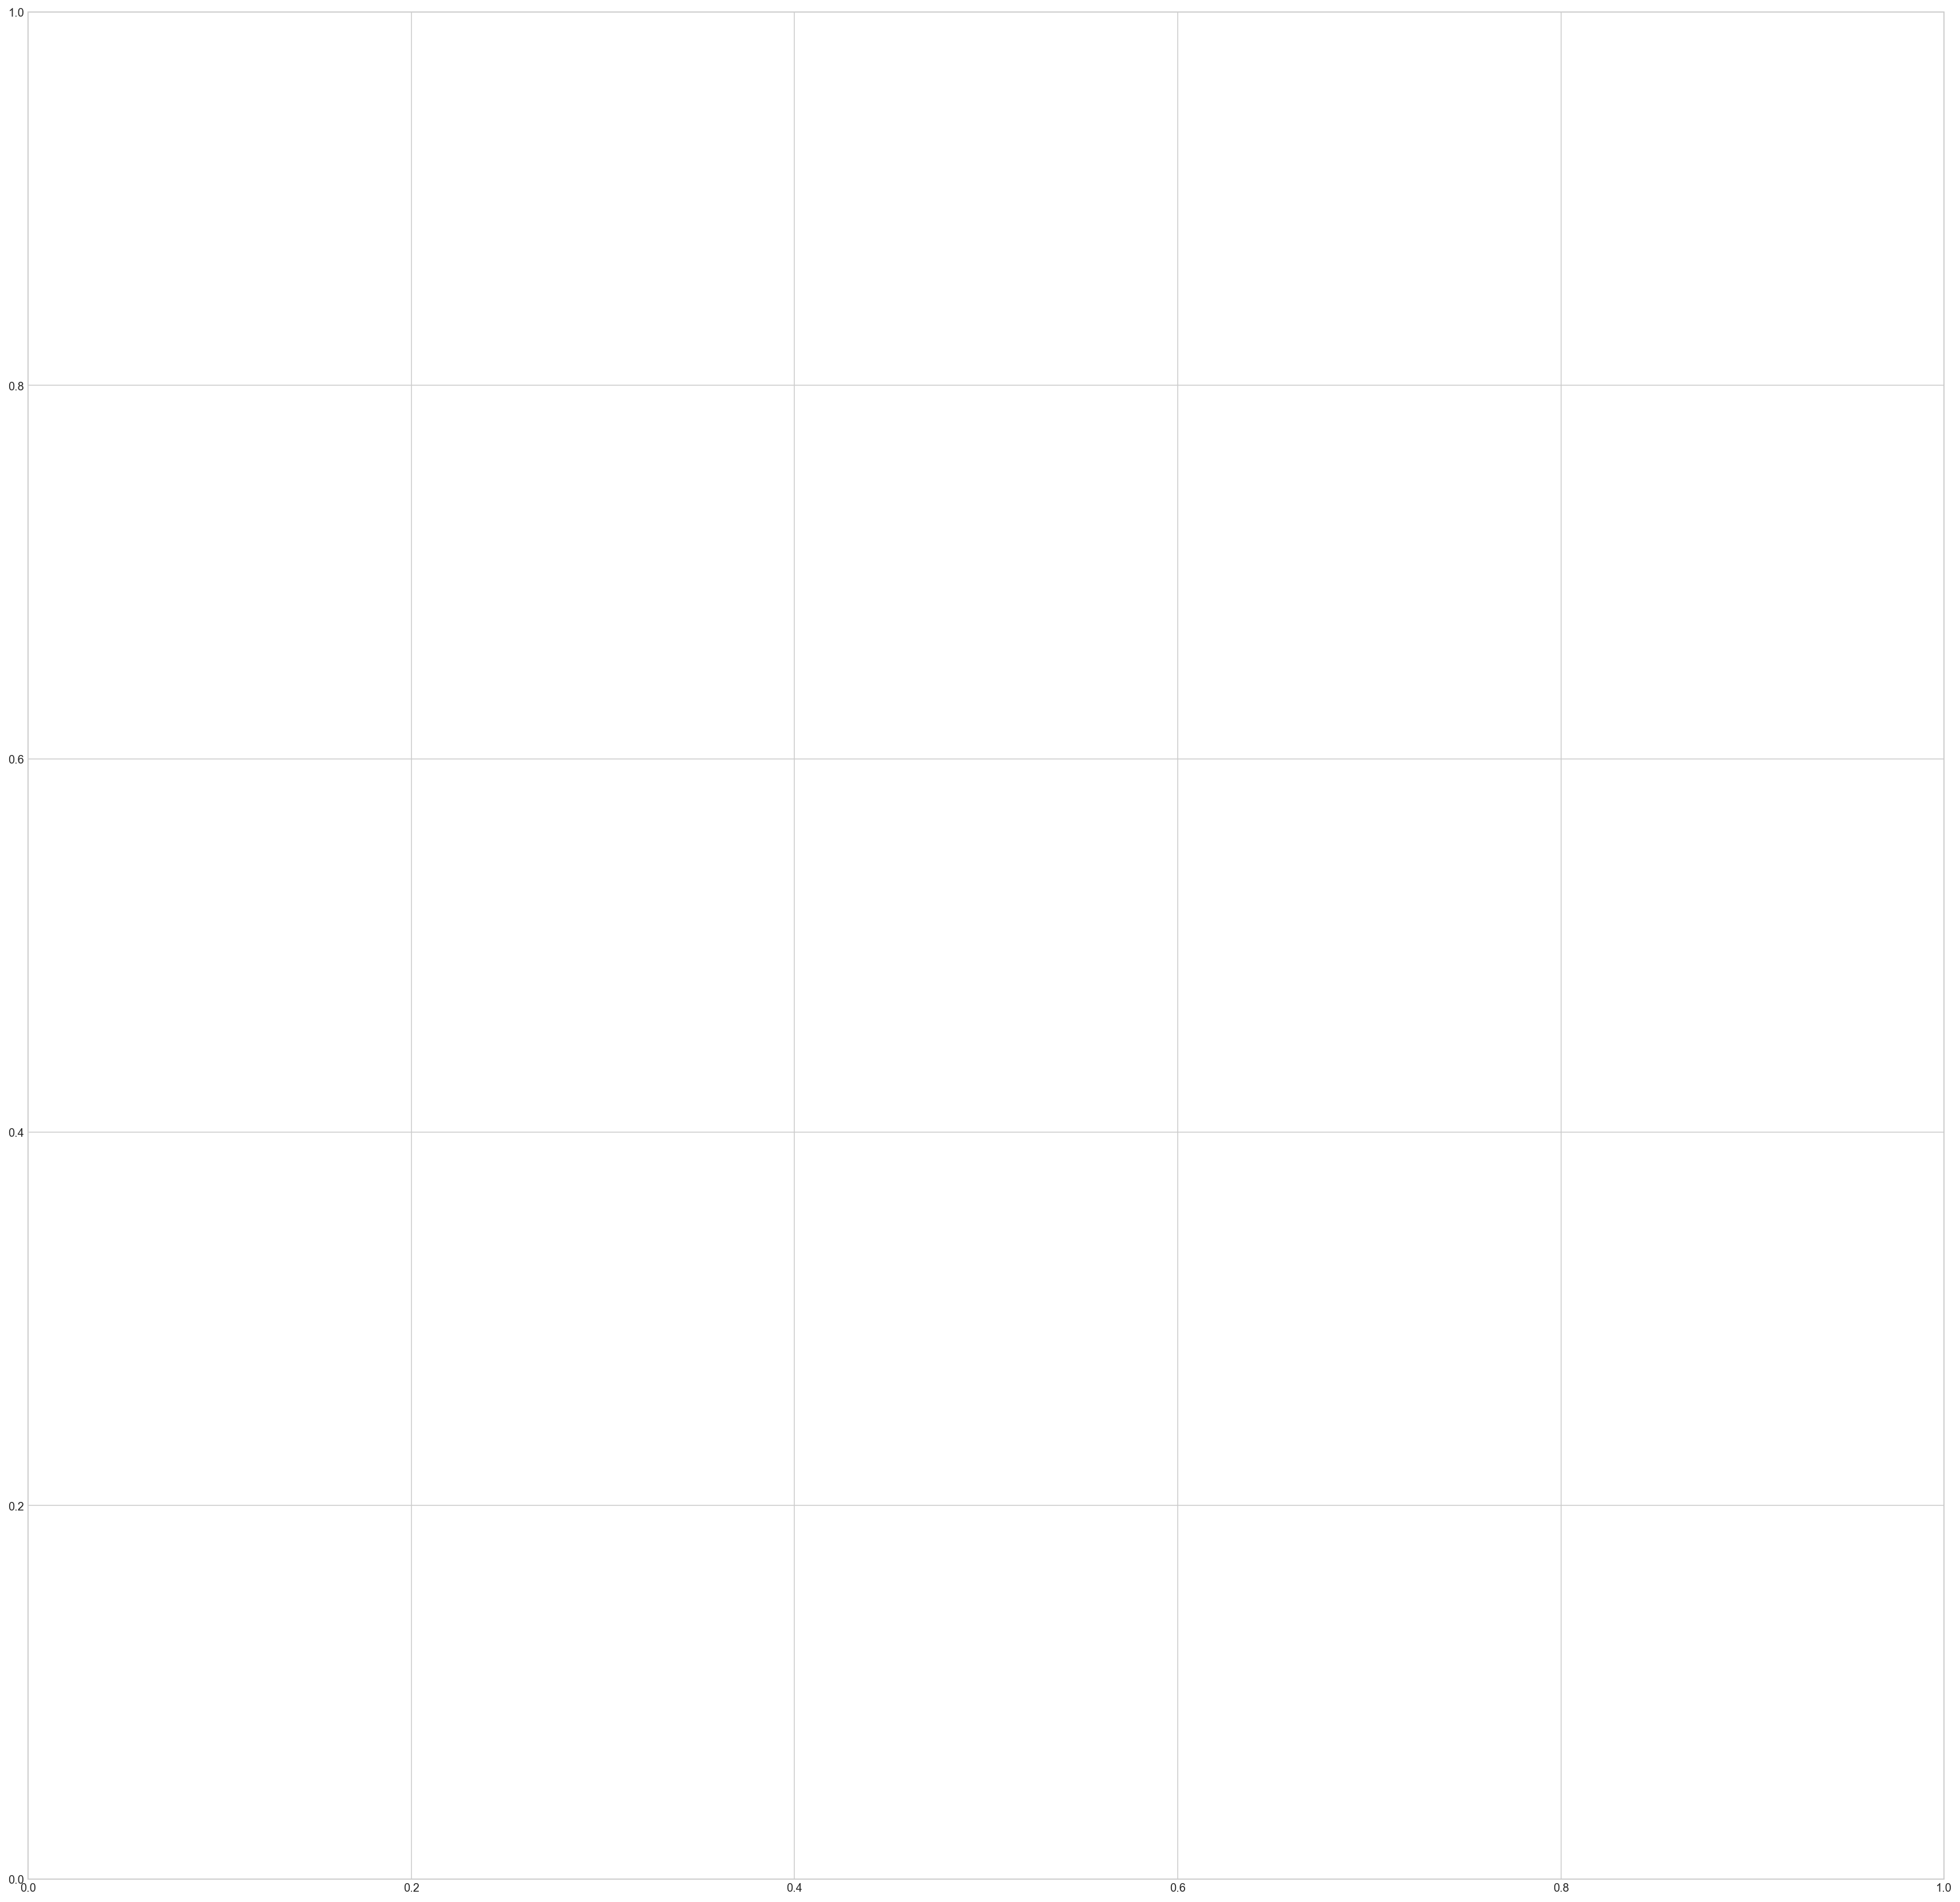

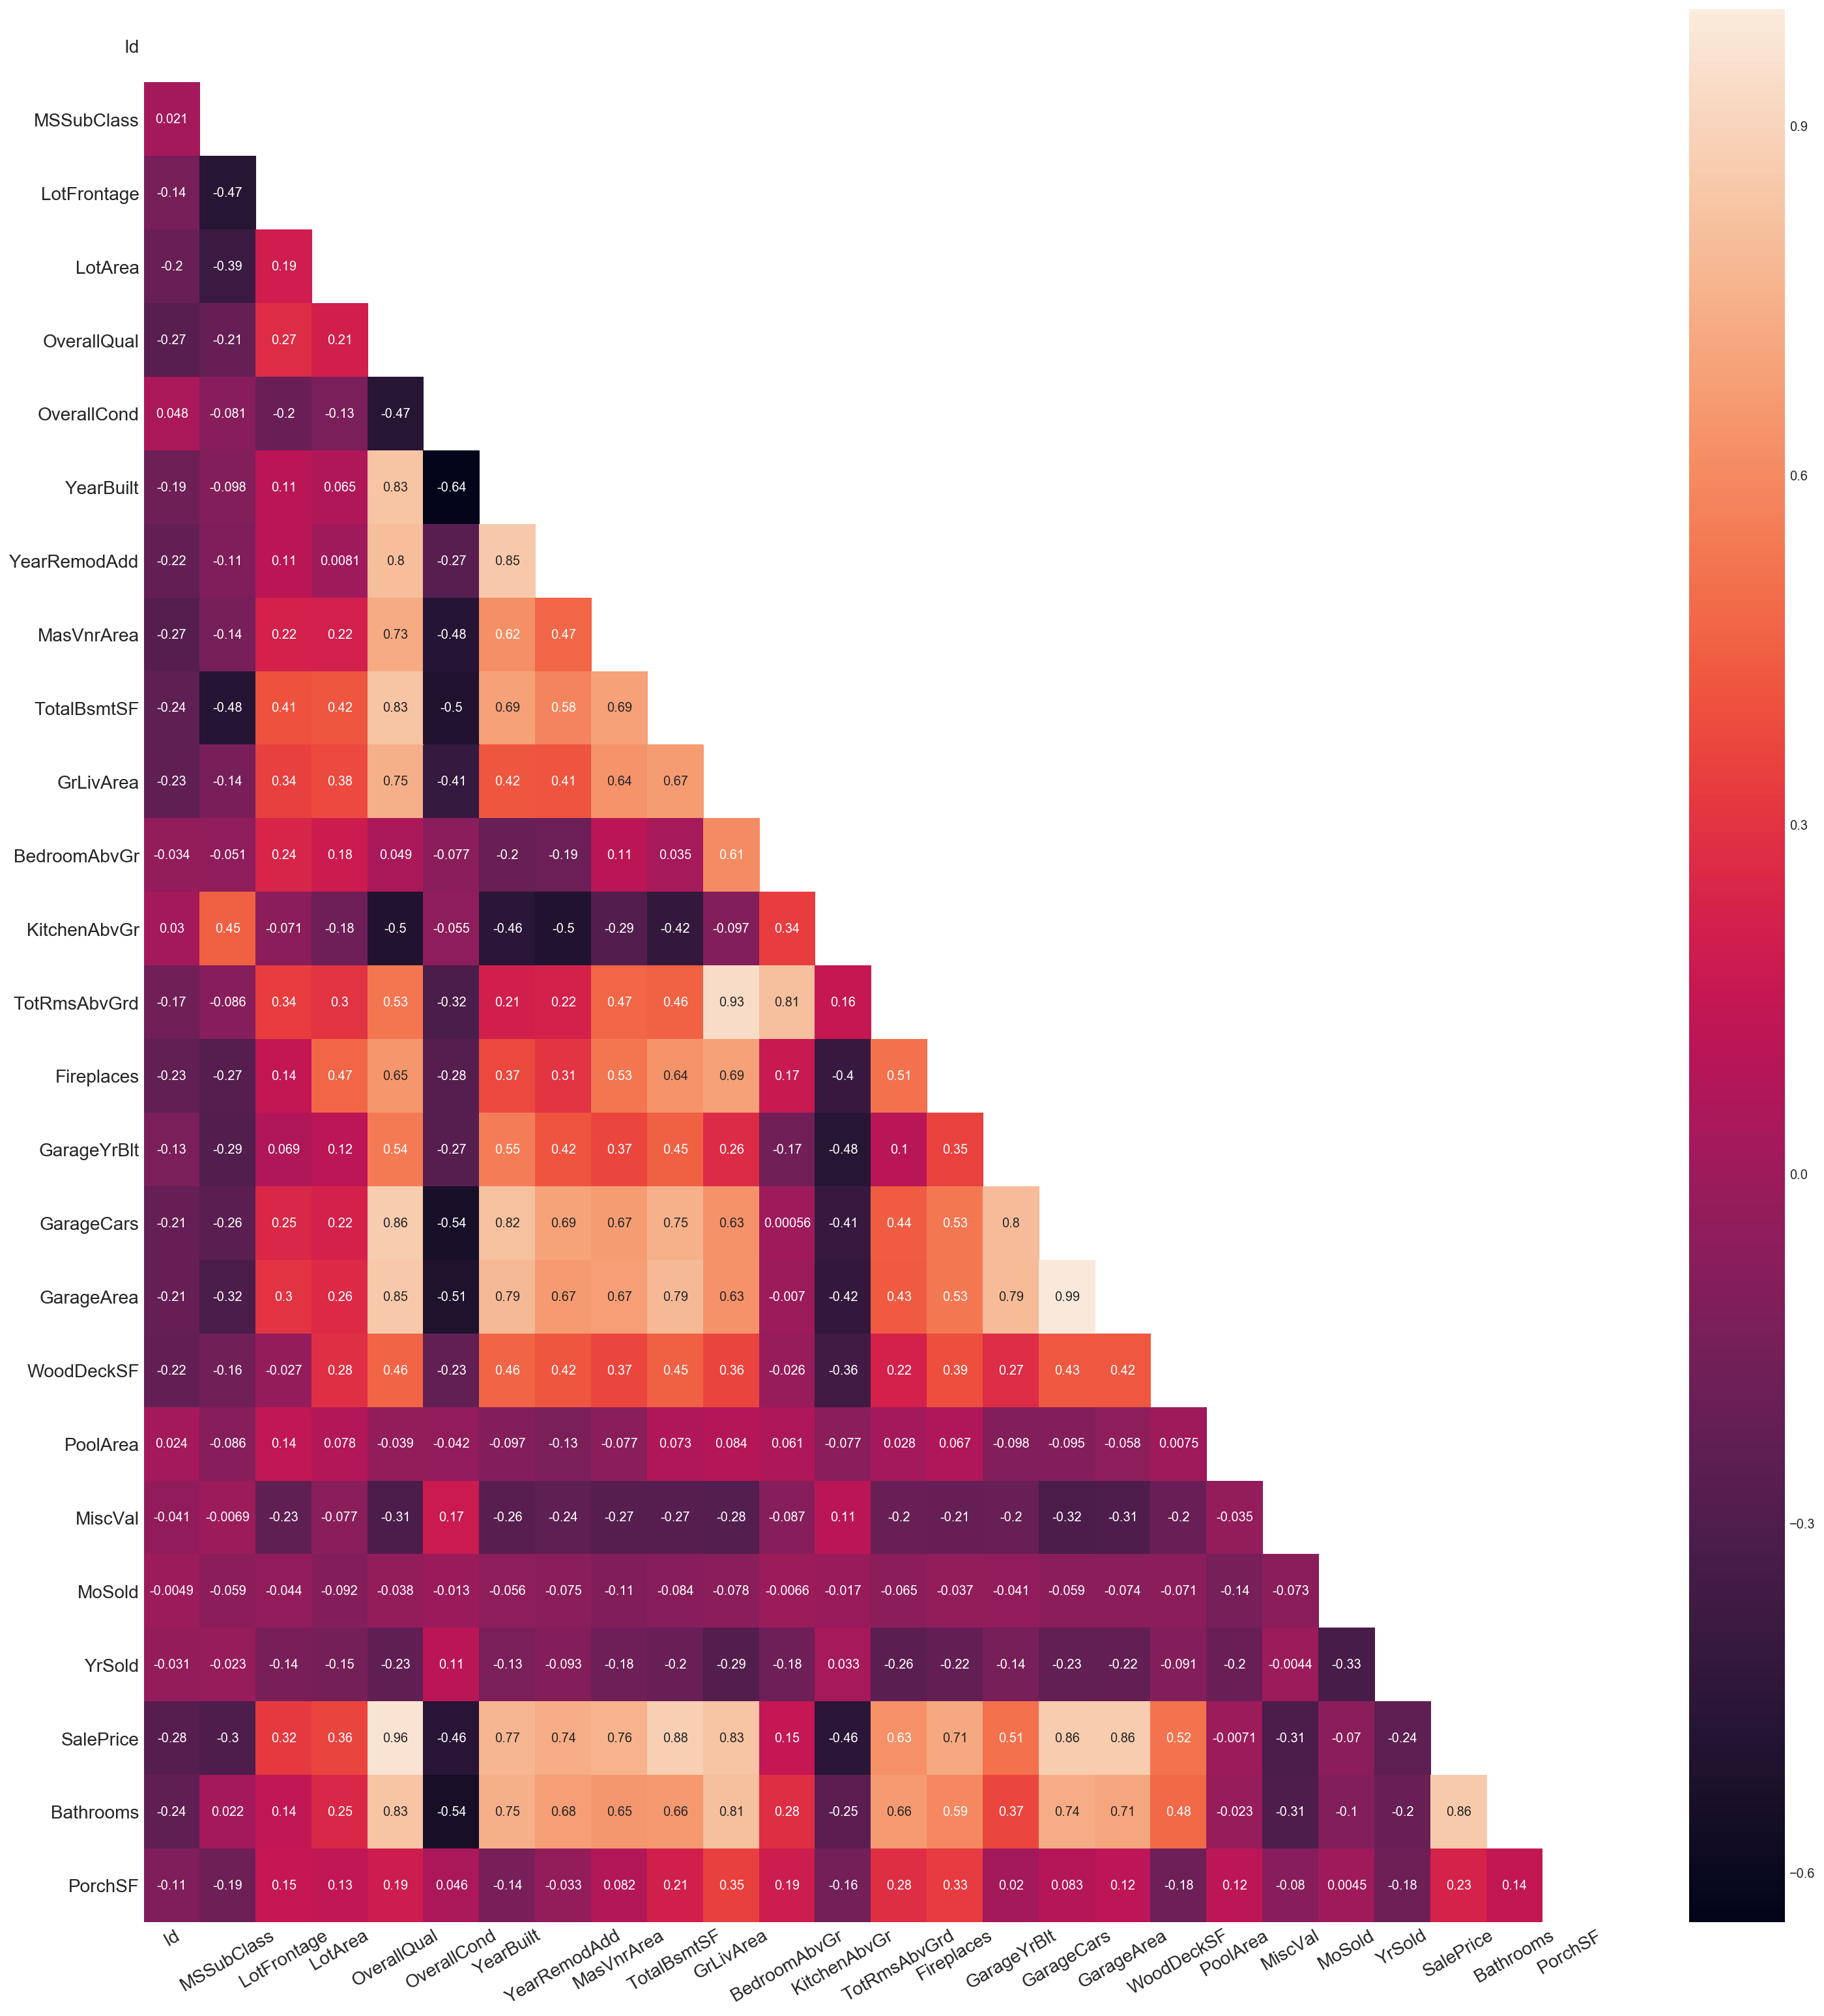

In [36]:
house_num = feature_dataframe(house)

In [13]:
# High correlations
list_fixed_Features = ['LotFrontage','LotArea','OverallQual','MassVNrArea','TotalBsmtSF','1stFlrSF',
                       '2ndFlrSF','GrlivArea','BedroomAbvGr','TotalRmsAbvGrd','Fireplaces','WoodDeckSF',
                      'Bathrooms','PorchSF']

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
house_name = house.select_dtypes(exclude=numerics)
house_name.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [15]:
house_pre = house_num.loc[house_num['YrSold'] < 2010]
house_pre.shape

(1278, 26)

In [16]:
house_post = house_num.loc[house_num['YrSold'] == 2010 ]
house_post.shape

(172, 26)

#### Import my_def.py

In [17]:
%run -i ./pythons/my_def.py

<Figure size 432x288 with 0 Axes>

In [18]:
year_in_float(house_pre)

./pythons/my_def.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  house_num['HouseAge'] = house_num[list_Years[0]] - house_num[list_Years[1]] + house_num[list_Years[4]]
./pythons/my_def.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  house_num['GarageAge'] = house_num[list_Years[0]] - house_num[list_Years[2]]
./pythons/my_def.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [19]:
# Features Selection on PRE-DATA
y = house_pre['SalePrice'].values
house_pre.drop(labels=['Id','SalePrice'],axis=1, inplace=True)
X = house_pre.copy()

C:\Users\Shaynie\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'PoolArea', 'MiscVal', 'Bathrooms',
       'PorchSF', 'HouseAge', 'GarageAge', 'RemodAge'],
      dtype='object')


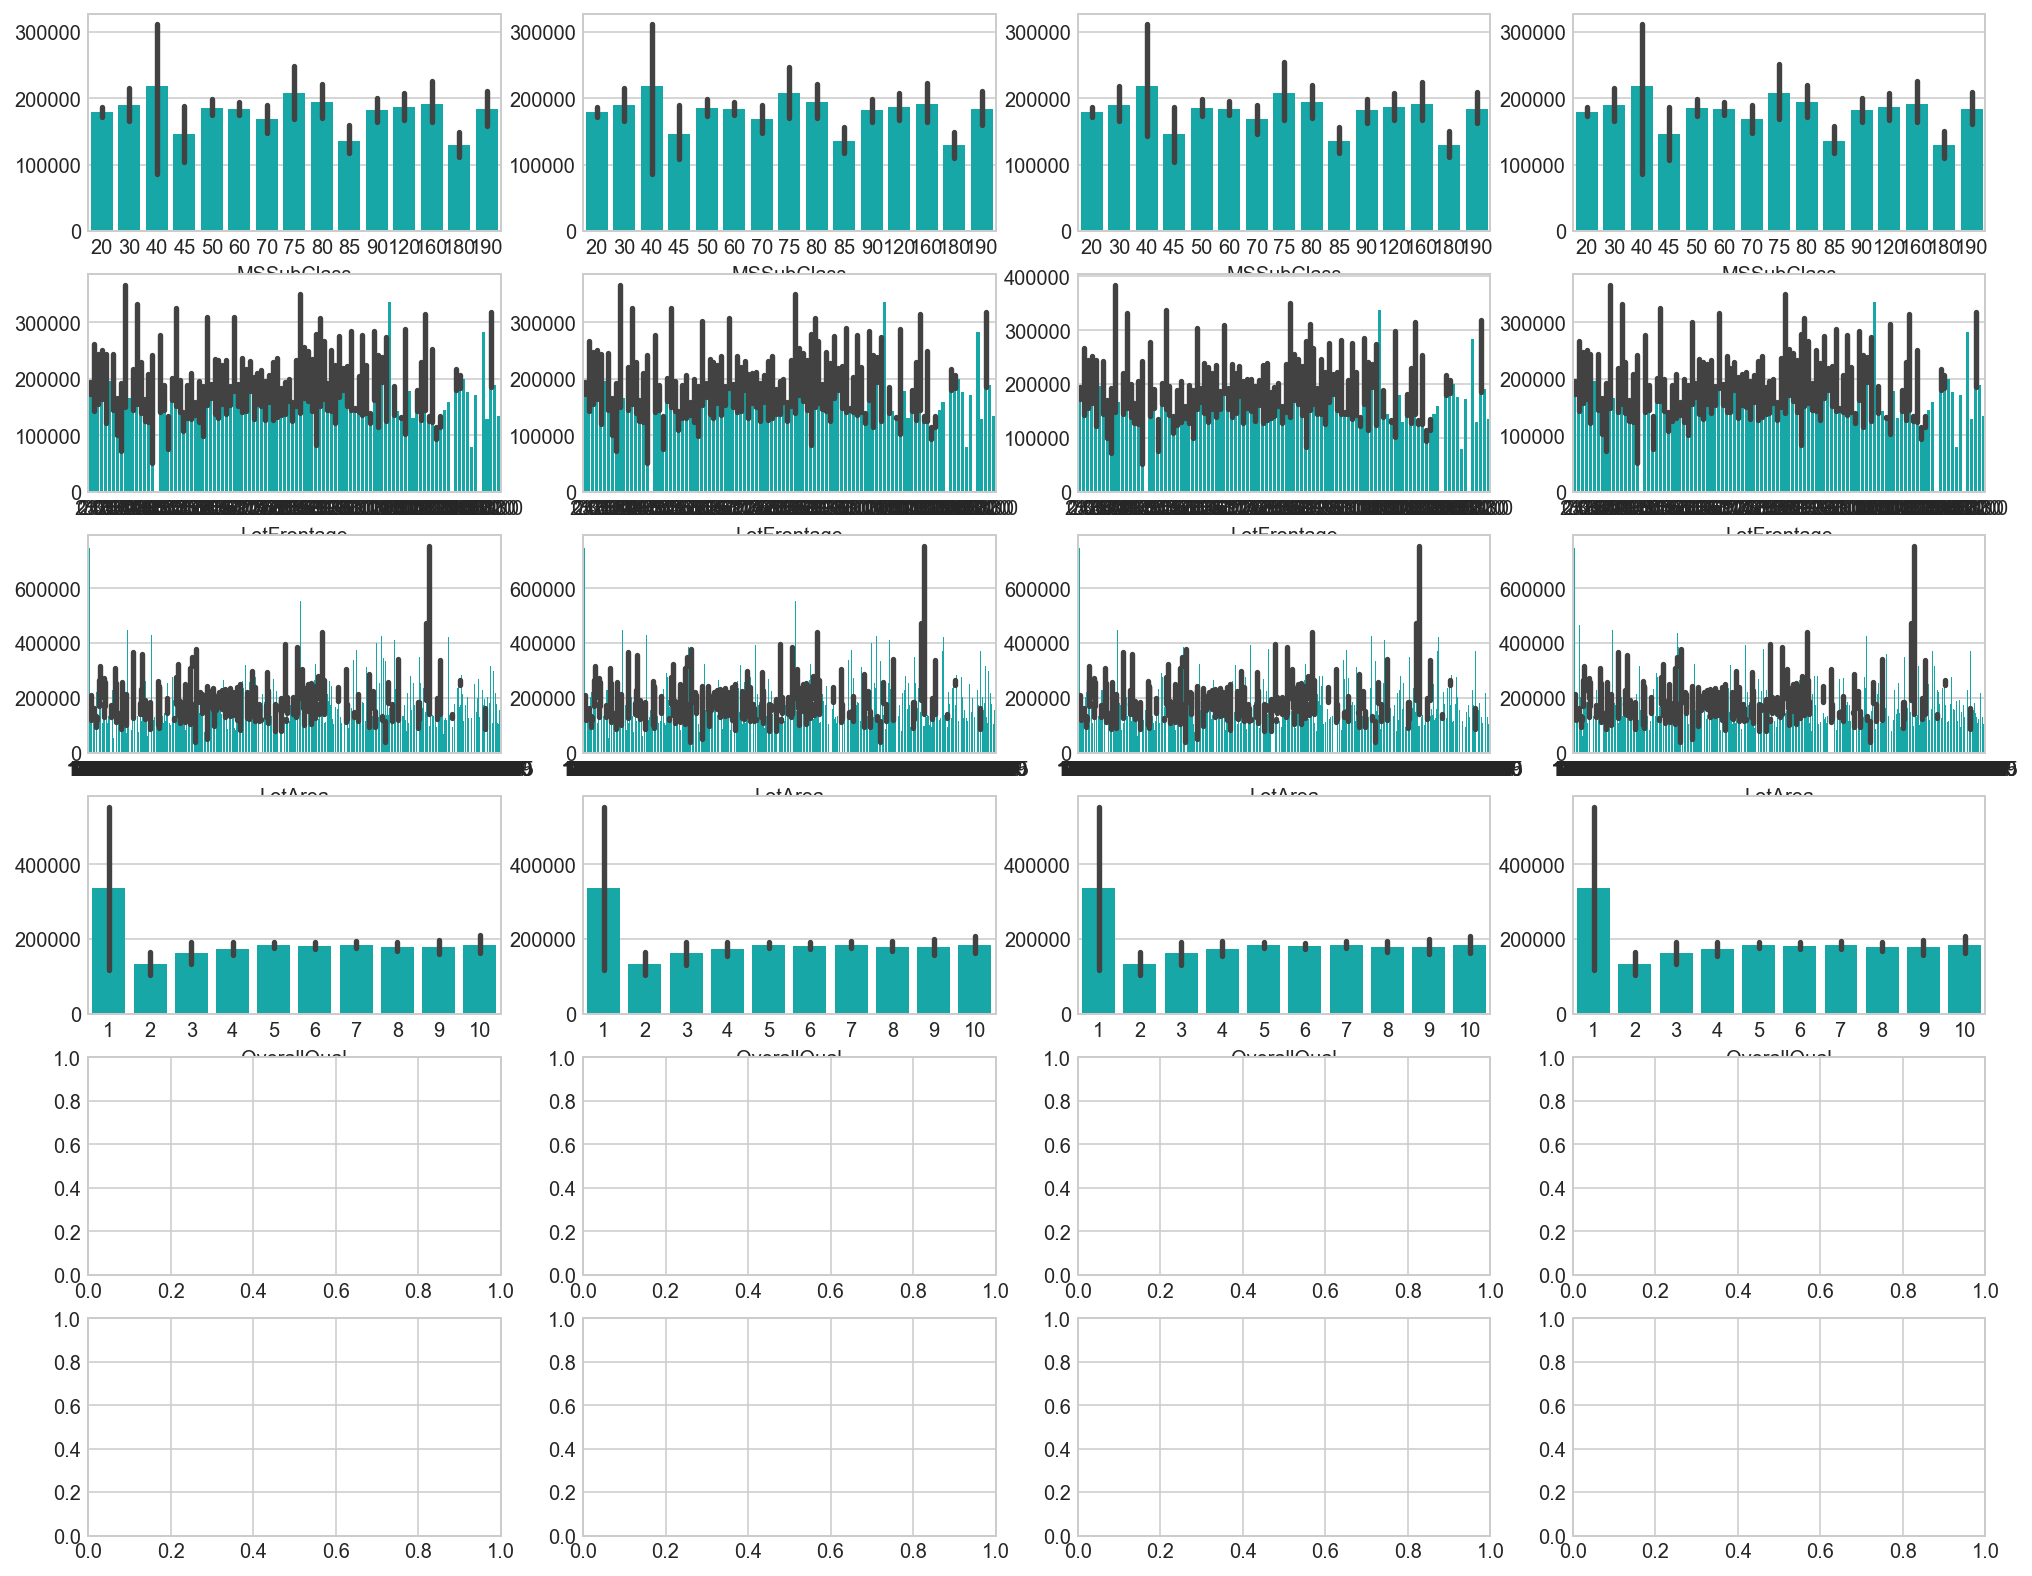

In [31]:
features = X.columns
print(features)
plotting_features_vs_target(features, X, y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026BC8E65CC0>,
      dtype=object)

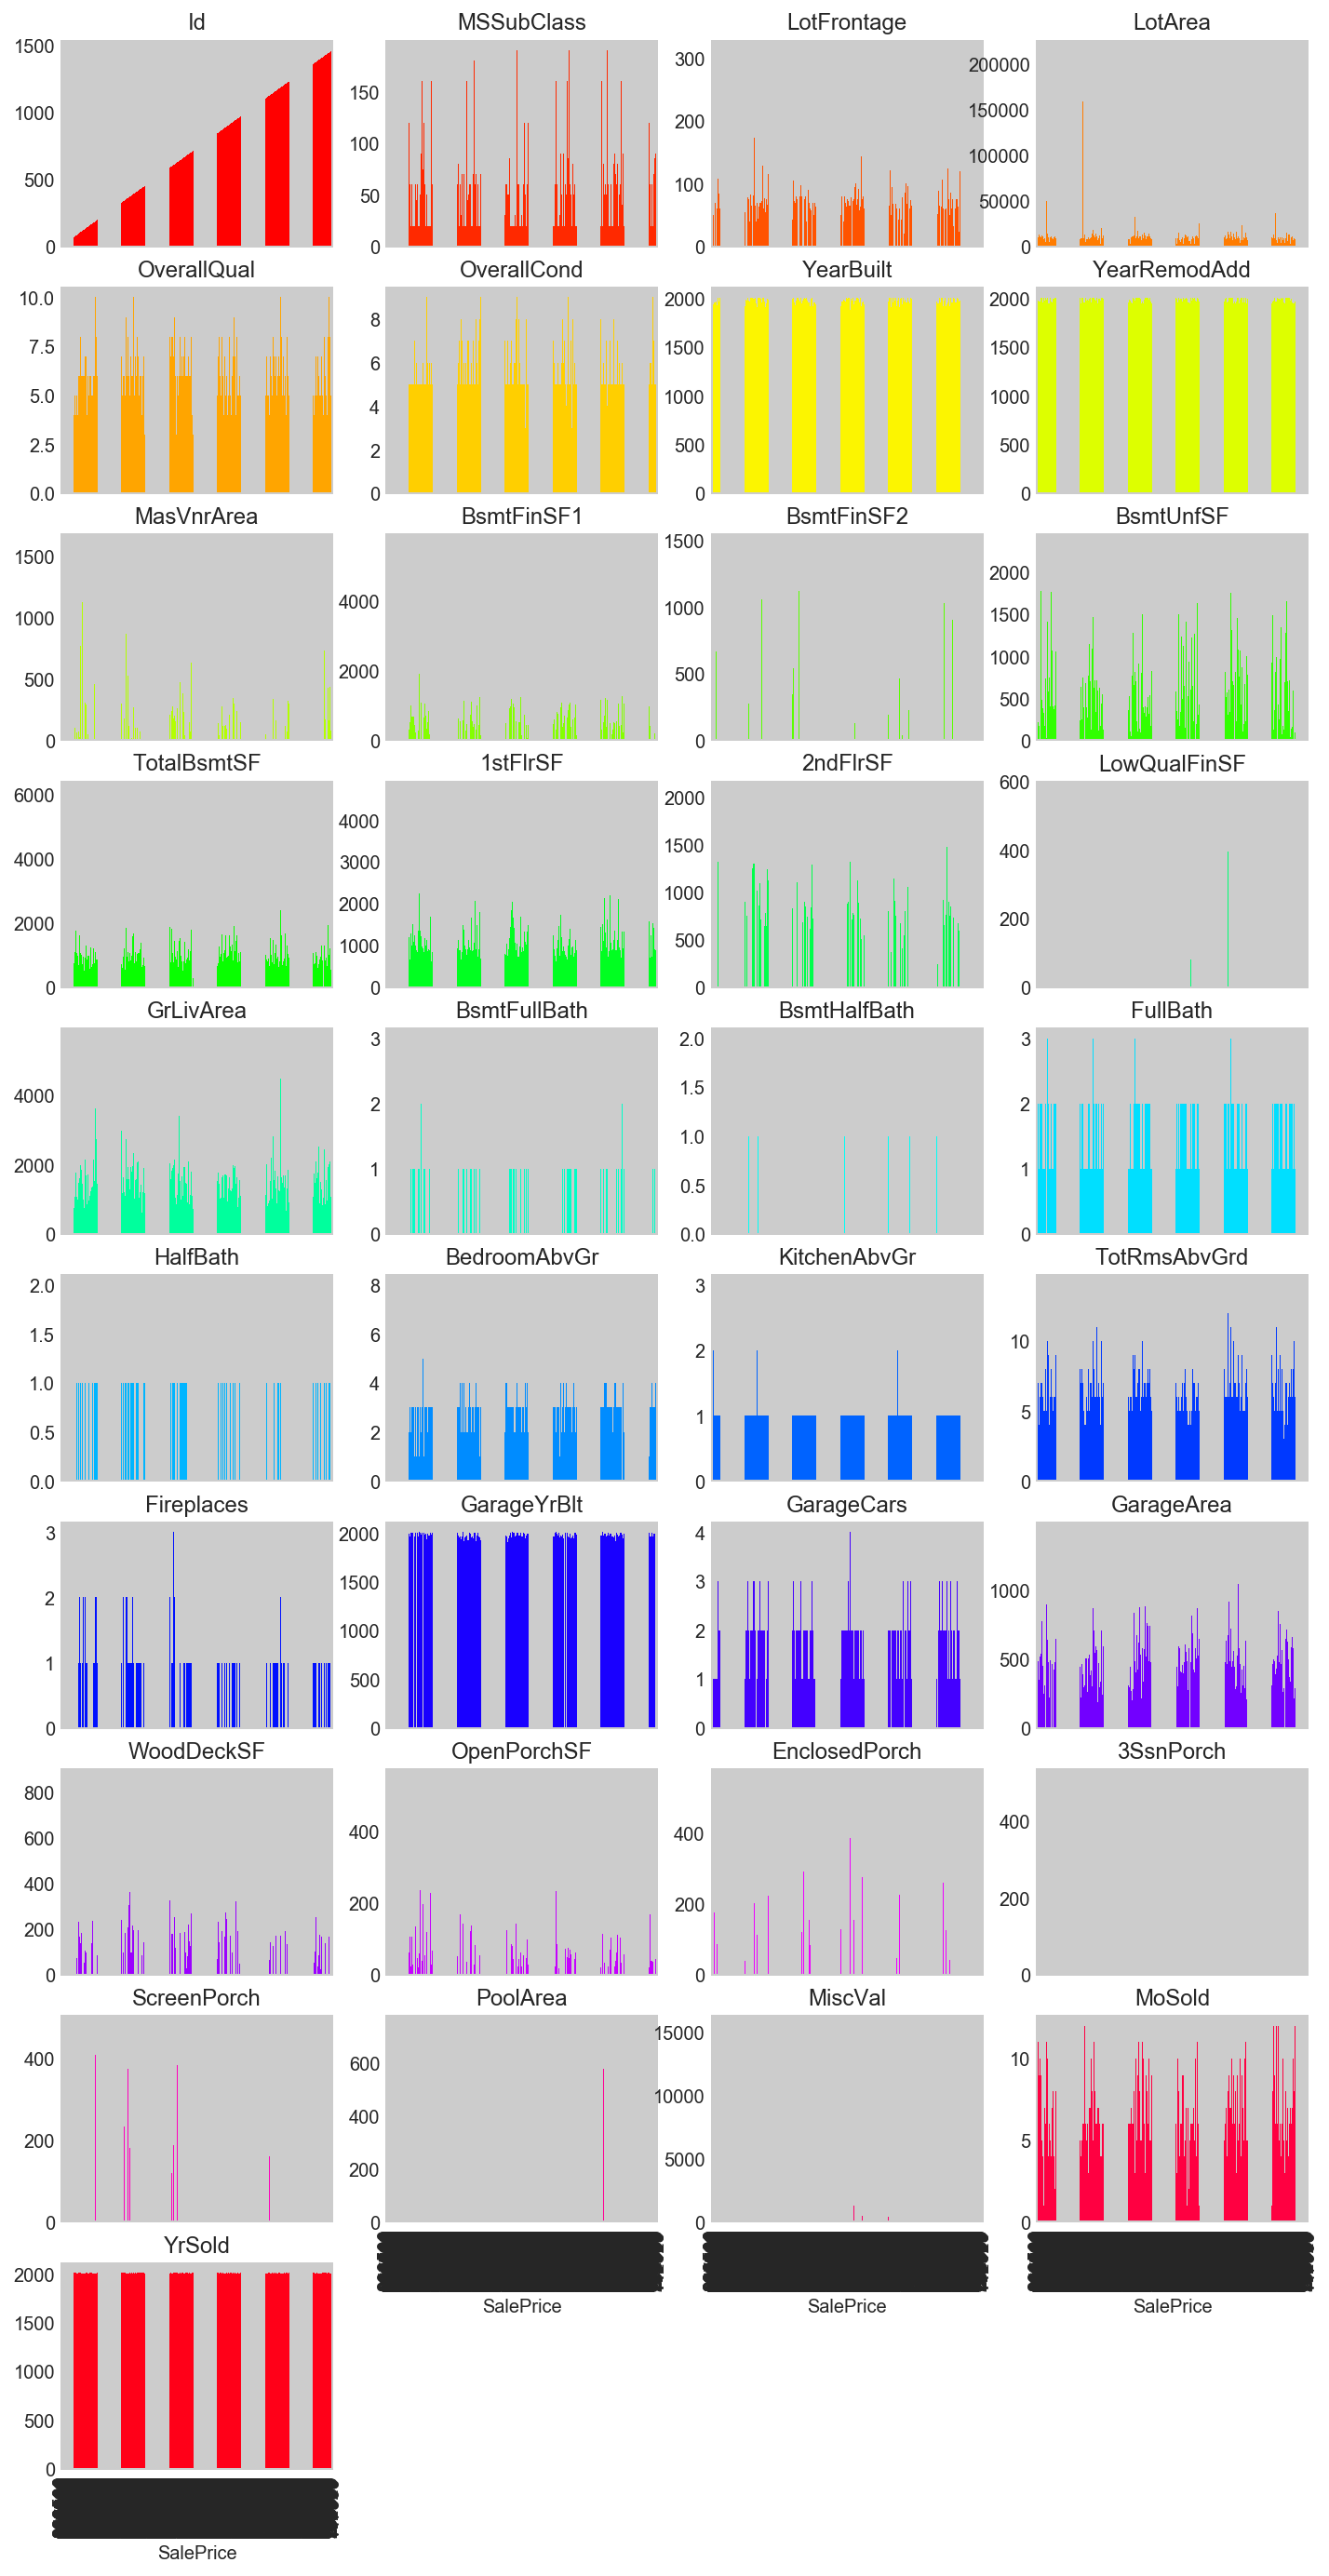

In [29]:
# house.plot(kind='bar', x='SalePrice', figsize=(17,14), subplots=True, layout=(10,4), legend=False, colormap='hsv')

In [ ]:
X.shape

In [ ]:
y.shape

#### Import linear_regression.py

In [ ]:
%run -i ./pythons/linear_regression.py
%run -i ./pythons/cross_validation.py

In [ ]:
linear_scores = my_linear_regression(X, y)
linear_scores

In [ ]:
# POST-DATA
y = house_post['SalePrice'].values
y.shape

In [ ]:
X.shape

In [ ]:
linear_scores_post = my_linear_regression(X, y)
linear_scores_post

### Characterize your model. How well does it perform? What are the best estimates of price?

In [ ]:
# Non renovated features:
# - The neighborhood
# - Square feet
# - Bedrooms, bathrooms
# - Basement and garage space
list_non_renovated = ['Neighborhood','LotArea','BedroomAbvGr','Bathrooms','TotalBsmtSF','GarageArea']
# ARE renovate-able:
# - Roof and exterior features
# - "Quality" metrics, such as kitchen quality
# - "Condition" metrics, such as condition of garage
# - Heating and electrical components
list_renovate_able = ['RoofStyle','RoofMatl','Exterior1st','Exterior2nd','KitchenQual','GarageCond','HeatingQC','Electrical']

# Selected features:
# - RootStyle & RoofMatl
# - Exterior1st, Exterior2nd
# - HeatingQC (overall) 

In [ ]:
def my_multi_line_charts(plt):
    bears = [10, 58, 85, 115, 139, 182]
    dolphins = [150, 75, 32, 14, 8, 5]
    whales = [80, 50, 100, 75, 90, 70]
    x = [0, 1, 2, 3, 4, 5]
    years = ["2009", "2010", "2011", "2012", "2013", "2014"]

    # we can make multiple calls to plt.plot 
    # to show multiple series on the same chart
    plt.plot(x, bears, '#16a085', marker='o', linewidth=3.0, label='Bears')
    plt.plot(x, dolphins, '#c0392b', marker='s', linewidth=3.0, label='Dolphins')
    plt.plot(x, whales, '#3498db', marker='^', linewidth=3.0, label='Whales')

    # because we've assigned labels to each series
    # we can get a legend for free
    # loc=9 means "top center"
    plt.legend(loc=9)
    plt.title("Number of animals each year")
    plt.xlabel("Years")
    plt.xticks(x, years)

    plt.show()
my_multi_line_charts(plt)

In [ ]:

def my_scatter_plot(plt):
    sizes = [700, 650, 720, 630, 710, 640, 600, 640, 670]
    prices = [175, 170, 205, 120, 220, 130, 105, 145, 190]
    labels = ["$175", "$170", "$205", "$120", "$220", "$130", "$105", "$145", "$190"]

    plt.scatter(sizes, prices, marker='s', s=40, color='#2ecc71')

    # label each point
    for label, friend_count, minute_count in zip(labels, sizes, prices):
        plt.annotate(label,
                     xy=(friend_count, minute_count),  # put the label with its point
                     xytext=(5, -5),  # but slightly offset
                     textcoords='offset points')

    plt.title("House prices")
    plt.xlabel("Size in m2")
    plt.ylabel("Thousand $")
    plt.show()
    
my_scatter_plot(plt)

In [ ]:
house['YrSold'].unique()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: